# Similarity-Based Constraint Score For Feature Selection Notebook

In this notebook, you will find a comprehensive summary of the project, detailing key steps undertaken and presenting results obtained during the implementation of our innovative constraint score.



## Part 1: Contraint score 4
Firstly we would like to implement the contraints score 4: $ \begin{equation}
SC^4_r = \frac{\tilde{f_r}^TL\tilde{f_r}}{\tilde{f_r}^TD\tilde{f_r}}*\frac{{f_r}^TL^\mathcal{M}f_r}{{f_r}^TL^\mathcal{C}f_r} = SL_r*SC_r
\end{equation} $
And see if our results correspond to the outcomes in the thesis by Maryam Kalakesh on the wine dataset.

In [102]:
%cd /Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS
import numpy as np
import pandas as pd
import sklearn.datasets as skd

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS


/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [103]:
from c_scores import laplacian_score
X = skd.load_wine()
X_wine = X.data
laplacian_score(X_wine) ## Compute the Laplacian Score for features of the wine dataset
X_wine.shape

(178, 13)

In [104]:
from c_scores import get_constraints
X_target = X.target[np.newaxis].T
get_constraints(X_target)[0]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [105]:
## Generate random constraints for the wine dataset
from c_scores import generate_constraints
X_target_constraint= generate_constraints(X_target, 60)[np.newaxis].T

In [106]:
##compute the constraint score for the wine dataset
from c_scores import constraint_score_1
X_wine = X.data
constraint_score_4 = laplacian_score(X_wine)*constraint_score_1(X_wine,X_target)
## The ranks of the features according to the constraint score are stored in the variable features
features = np.argsort(constraint_score_4)
features

array([12,  4,  6,  9,  3, 11, 10,  5,  0,  2,  1,  8,  7])

In [107]:
# ##plot the scores for how many features are kept based on there constraint scores.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as Knn
import matplotlib.pyplot as plt
# n = 14
# Accuracy = []
# knn = Knn(n_neighbors=1)
# for i in range(1,n):
#     X_wine = np.concatenate((X.data,X.target[np.newaxis].T), axis=1)
#     X_wine = np.delete(X_wine, features[i:], axis=1)
#     X_wine_train , X_wine_test = train_test_split(X_wine, test_size=0.4)  ## REDO the repartition of the data
#     y_train = X_wine_train[:,-1]
#     y_test = X_wine_test[:,-1]
#     X_wine_train = np.delete(X_wine_train, -1, axis=1)
#     X_wine_test = np.delete(X_wine_test, -1, axis=1)
#     knn.fit(X_wine_train, y_train)
#     y_pred = knn.predict(X_wine_test)
#     Accuracy.append(np.mean(y_pred == y_test))

# plt.plot(range(1,n),Accuracy)
# plt.xlabel('Number of features')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Number of features')
# plt.show()



(142, 1) 1
(142, 2) 2
(142, 3) 3
(142, 4) 4
(142, 5) 5
(142, 6) 6
(142, 7) 7
(142, 8) 8
(142, 9) 9
(142, 10) 10
(142, 11) 11
(142, 12) 12
(142, 13) 13


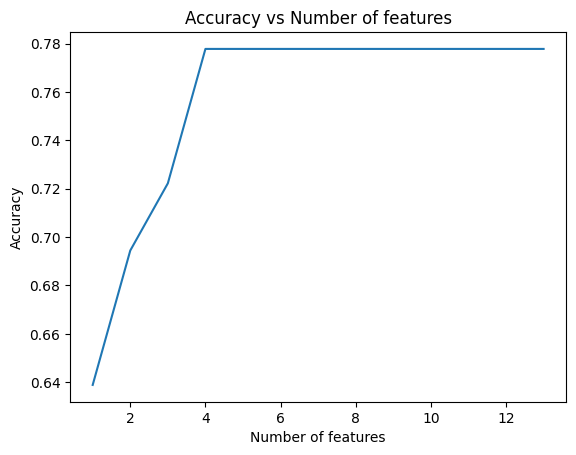

In [108]:
n = 14
Accuracy = []
knn = Knn(n_neighbors=1)
X_wine = np.concatenate((X.data,X.target[np.newaxis].T), axis=1)
X_wine_train , X_wine_test = train_test_split(X_wine, test_size=0.2, random_state=42) ## Manually split the data the sameway
y_train = X_wine_train[:,-1]
y_test = X_wine_test[:,-1]
X_wine_train = np.delete(X_wine_train, -1, axis=1)
X_wine_test= np.delete(X_wine_test, -1, axis=1)

for i in range(1,n): 
    X_wine_train_i = np.delete(X_wine_train, features[i:], axis=1)
    X_wine_test_i = np.delete(X_wine_test, features[i:], axis=1)
    knn.fit(X_wine_train_i, y_train)
    y_pred = knn.predict(X_wine_test_i)
    Accuracy.append(np.mean(y_pred == y_test))
    print(X_wine_train_i.shape,i)

plt.plot(range(1,n),Accuracy)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of features')
plt.show()


### Problem : we need to correctly split the data : 
78 données caractérisées par 13 attributs (n=178, d=13). Ces données sont divisées en 3 classes ayant pour effectif 59, 71 et 48 données. Nous sélectionnons 30, 36 et 24 données de chaque classe afin de constituer la base d’apprentissage.

In [109]:
target = X.target
X_class_1 = target == 0
X_class_2 = target == 1
X_class_3 = target == 2

# now we need 30 prototypes for the first class 36 for the second and 24 for the third
X_class_1 = X.data[X_class_1]
X_class_2 = X.data[X_class_2]
X_class_3 = X.data[X_class_3]

X_class_1 = X_class_1[:30]
X_class_2 = X_class_2[:36]
X_class_3 = X_class_3[:24]

X_data_train_2 = np.concatenate((X_class_1,X_class_2,X_class_3), axis=0)
X_target_train_2 = np.concatenate((np.zeros(30),np.ones(36),np.ones(24)*2), axis=0)
# now we need to drop the prototypes from the data
X_data = X.data
X_data_test_2 = np.delete(X_data, np.concatenate((np.arange(30),np.arange(59,95),np.arange(131,155))), axis=0)
X_target_test_2 = np.delete(X.target, np.concatenate((np.arange(30),np.arange(59,95),np.arange(131,155))), axis=0)


#now we have our training and test data


In [110]:
# We calculate the constraint score for the training data
constraint_score_4 = laplacian_score(X_data_train_2)*constraint_score_1(X_data_train_2,X_target_train_2[np.newaxis].T)
features = np.argsort(constraint_score_4)
features

array([12,  4,  5,  6, 10,  1,  3,  0,  2, 11,  9,  8,  7])

(88, 1) 1
(88, 2) 2
(88, 3) 3
(88, 4) 4
(88, 5) 5
(88, 6) 6
(88, 7) 7
(88, 8) 8
(88, 9) 9
(88, 10) 10
(88, 11) 11
(88, 12) 12
(88, 13) 13


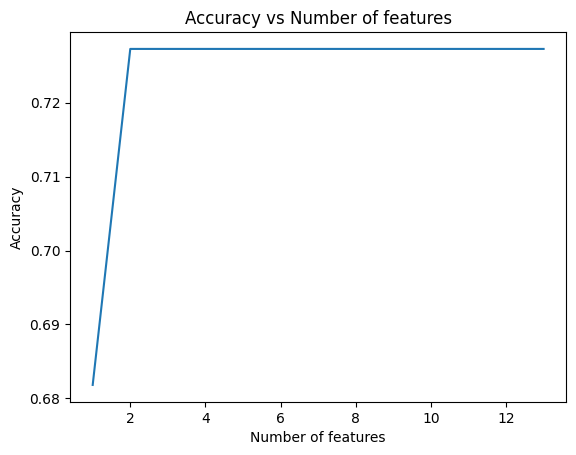

In [113]:
n = 14
Accuracy = []
knn = Knn(n_neighbors=1)

for i in range(1,n): 
    X_wine_train = np.delete(X_data_train_2, features[i:], axis=1)
    X_wine_test = np.delete(X_data_test_2, features[i:], axis=1)
    y_train = X_target_train_2
    y_test = X_target_test_2
    knn.fit(X_wine_train, y_train)
    y_pred = knn.predict(X_wine_test)
    Accuracy.append(np.mean(y_pred == y_test))
    print(X_wine_test.shape,i)

plt.plot(range(1,n),Accuracy)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of features')
plt.show()

